In [28]:
import matplotlib
matplotlib.use('Agg')  # Backend non-interactif
%matplotlib inline

import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import astropy.units as u
import random
import pandas as pd
import copy
import json

from textwrap import fill
from astropy.table import Table, vstack, Column
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.coordinates import search_around_sky
from matplotlib.patches import Rectangle
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
from astropy.coordinates import angular_separation
import astropy.units as u
from astropy.table import join
from collections import Counter

from constantes import LIM_FLUX_CLUSTER, LIM_FLUX_AGN, SEARCH_RADIUS_CLUSTER, SEARCH_RADIUS_AGN, EXT_LIKE_C1, EXT_LIKE_C2, EXT_C1_C2, EXT_LIKE_C1_new, EXT_LIKE_C2_new, EXT_C1_C2_new, PNT_DET_ML_SPURIOUS, EXT_LIKE_SPURIOUS, window_size_arcmin
from constantes import print_parameters

print_parameters()


╭─────────────────────────────────────────────╮
│                  PARAMÈTRES                 │
├─────────────────────────────────────────────┤
│ LIM_FLUX_CLUSTER      : 1.00e-15 erg/cm²/s 
│ LIM_FLUX_AGN          : 1.00e-15 erg/cm²/s 
│ SEARCH_RADIUS_CLUSTER : 30.00    arcsec    
│ SEARCH_RADIUS_AGN     : 10.00    arcsec    
│ EXT_LIKE_C1           : 33       
│ EXT_LIKE_C2           : 15       
│ EXT_C1_C2             : 5        
│ EXT_LIKE_C1_new       : 80       
│ EXT_LIKE_C2_new       : 35       
│ EXT_C1_C2_new         : 13       
│ window_size           : 7.0      arcmin    
│ PNT_DET_ML_SPURIOUS   : 20       
│ EXT_LIKE_SPURIOUS     : 15       
╰─────────────────────────────────────────────╯


# **Choix des donnees**

Si Simulation_1_2_3 == True, les trois simulations seront utilisees, sinon seulement les simulations 2 et 3

In [29]:
Simulation_1_2_3 = False

# **Chargement des donnees**

In [30]:
dossier = "Simulations_2_3"

if(Simulation_1_2_3):
    dossier = "Simulations_1_2_3"
    catalog_path_befXamin_simu1 = os.path.expanduser('~/Documents/TransformerProject/data/Simulation1/XFSII_25_sx_p18_b05rc02_output.csv')
    data_befXamin_simu1 = Table.read(catalog_path_befXamin_simu1)

catalog_path_befXamin_simu2 = os.path.expanduser('~/Documents/TransformerProject/data/Simulation2/fsII_25_lensed_AGN1/XFSII_25_p18_b05rc02_lensed_1e13Mo_output_cleaned.fits')
catalog_path_befXamin_simu3 = os.path.expanduser('~/Documents/TransformerProject/data/Simulation3/fsII_25_lensed_AGN2/XFSII_25_p18_b05rc02_lensed_1e13Mo_output_cleaned.fits')

data_befXamin_simu2 = Table.read(catalog_path_befXamin_simu2)
data_befXamin_simu3 = Table.read(catalog_path_befXamin_simu3)

In [31]:
if(Simulation_1_2_3):
    current_cols = data_befXamin_simu1.colnames
    print("Colonnes actuelles:")
    print(current_cols)
    new_column_names = ['ID', 'R.A.', 'Dec', 'px', 'yx', 'm200', 'Tsl', 'Lx_soft', 'flux', 'flux_ABS', 'r500', 'z']

    # Renommer uniquement les colonnes 2 à 13
    for i in range(1, 13):
        data_befXamin_simu1.rename_column(current_cols[i], new_column_names[i-1])

    print("\nColonnes après renommage:")
    print(data_befXamin_simu1.colnames)


for colname in data_befXamin_simu2.colnames:
    # Vérifie si la colonne est numérique (int, float, etc.)
    if data_befXamin_simu2[colname].dtype.kind in 'iufc':
        # Convertit en float64 (meilleure précision que float32)
        data_befXamin_simu2[colname] = data_befXamin_simu2[colname].astype(np.float64)
        
# Afficher un aperçu de la data_befXamin_simu2 pour vérification
#print(data_befXamin_simu2)

for colname in data_befXamin_simu3.colnames:
    # Vérifie si la colonne est numérique (int, float, etc.)
    if data_befXamin_simu3[colname].dtype.kind in 'iufc':
        # Convertit en float64 (meilleure précision que float32)
        data_befXamin_simu3[colname] = data_befXamin_simu3[colname].astype(np.float64)
        
#print(data_befXamin_simu3)

print("\nColonnes issues des donnees des simulations 2 et 3:")
print(data_befXamin_simu3.colnames)


Colonnes issues des donnees des simulations 2 et 3:
['ID', 'R.A.', 'Dec', 'px', 'yx', 'm200', 'm500', 'Tsl', 'Lx_soft', 'flux', 'flux_ABS', 'rs', 'rvir', 'r500', 'z']


In [32]:
BORNE_INF_FLUX_AMAS_SELECT1 = 2.5*10**(-15)
BORNE_INF_FLUX_AMAS_SELECT2 = 5*10**(-15)

if(Simulation_1_2_3):
    print(f"Simulation 1 : Amas : {len( data_befXamin_simu1)}")
    print(f"               Amas F>2.5e-15 : {len( data_befXamin_simu1[data_befXamin_simu1['flux_ABS'] > BORNE_INF_FLUX_AMAS_SELECT1])}")
    print(f"               Amas F>5e-15 : {len( data_befXamin_simu1[data_befXamin_simu1['flux_ABS'] > BORNE_INF_FLUX_AMAS_SELECT2])}")

print(f"\nSimulation 2 : Amas : {len( data_befXamin_simu2)}")
print(f"               Amas F>2.5e-15 : {len( data_befXamin_simu2[data_befXamin_simu2['flux_ABS'] > BORNE_INF_FLUX_AMAS_SELECT1])}")
print(f"               Amas F>5e-15 : {len( data_befXamin_simu2[data_befXamin_simu2['flux_ABS'] > BORNE_INF_FLUX_AMAS_SELECT2])}")

print(f"\nSimulation 3 : Amas : {len( data_befXamin_simu3)}")
print(f"               Amas F>2.5e-15 : {len( data_befXamin_simu3[data_befXamin_simu3['flux_ABS'] > BORNE_INF_FLUX_AMAS_SELECT1])}")
print(f"               Amas F>5e-15 : {len( data_befXamin_simu3[data_befXamin_simu3['flux_ABS'] > BORNE_INF_FLUX_AMAS_SELECT2])}")



Simulation 2 : Amas : 16606
               Amas F>2.5e-15 : 1027
               Amas F>5e-15 : 599

Simulation 3 : Amas : 16606
               Amas F>2.5e-15 : 1027
               Amas F>5e-15 : 599


# **Amas trouves**

In [33]:
# Chargement des tables
path_match_clusters = os.path.expanduser(f'~/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/Clusters_matches_r{SEARCH_RADIUS_CLUSTER*3600:.0f}arcsec_flux{LIM_FLUX_CLUSTER}_40ks.fits')
data_match_clusters = Table.read(path_match_clusters)
print(f"Amas: {len(data_match_clusters)}")

path_match_AGN = os.path.expanduser(f'~/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/AGN_matches_r{SEARCH_RADIUS_AGN*3600:.0f}arcsec_flux{LIM_FLUX_AGN}_40ks.fits')
data_match_AGN = Table.read(path_match_AGN)
print(f"AGN: {len(data_match_AGN)}")

path_match_NC = os.path.expanduser(f'~/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/Spurious_40ks.fits')
data_match_NC = Table.read(path_match_NC)
print(f"Fausses sources: {len(data_match_NC)}")

Amas: 2184
AGN: 60950
Fausses sources: 30466


In [34]:
def CompteC1C2(data, name, guttenberg, EXT_C1_C2_new, EXT_LIKE_C1_new, EXT_LIKE_C2_new):
    
    data_numeric = data.to_pandas()

    # Définition des classes C1 et C2
    cond_C1 = np.logical_and((data_numeric['EXT'] > EXT_C1_C2_new) , (data_numeric['EXT_LIKE'] >= EXT_LIKE_C1_new))
    cond_C2 = np.logical_and(np.logical_and((data_numeric['EXT'] > EXT_C1_C2_new) , (data_numeric['EXT_LIKE'] < EXT_LIKE_C1_new))
                            , (data_numeric['EXT_LIKE'] > EXT_LIKE_C2_new))

    n_C1 = sum(cond_C1)
    n_C2 = sum(cond_C2)
    ni_C1_ni_C2 = len(data_numeric) - (n_C1+n_C2)

    if(guttenberg):
        print(f"\n                               {name}")
        print("="*70)
        print(f"Total dans le catalogue : {len(data_numeric)}")
        print(f"\nNombre d'amas dans la classe C1 (EXT>{EXT_C1_C2_new} ET EXT_LIKE>={EXT_LIKE_C1_new}): {n_C1}")
        print(f"Nombre d'amas dans la classe C2 (EXT>{EXT_C1_C2_new} ET {EXT_LIKE_C2_new}<EXT_LIKE<{EXT_LIKE_C1_new}): {n_C2}")
        print(f"Nombre d'amas ni dans C1, ni dans C2: {ni_C1_ni_C2}")
        print("="*70)

    return n_C1, n_C2

In [35]:
n_C1_AMAS, n_C2_AMAS = CompteC1C2(data_match_clusters, "AMAS", False, EXT_C1_C2_new, EXT_LIKE_C1_new, EXT_LIKE_C2_new)
n_C1_AGN, n_C2_AGN = CompteC1C2(data_match_AGN, "AGN", False, EXT_C1_C2_new, EXT_LIKE_C1_new, EXT_LIKE_C2_new)
n_C1_NC, n_C2_NC = CompteC1C2(data_match_NC, "NC", False, EXT_C1_C2_new, EXT_LIKE_C1_new, EXT_LIKE_C2_new)

n_C1_tot = n_C1_AMAS+n_C1_AGN+n_C1_NC
n_C2_tot = n_C2_AMAS+n_C2_AGN+n_C2_NC

print(f"Nombre total de sources C1: {n_C1_tot}")
print(f"Nombre total de sources C2: {n_C2_tot}")

TVP_C1 = n_C1_AMAS/len(data_match_clusters)
TVP_C2 = n_C2_AMAS/len(data_match_clusters)

TFP_C1 = (n_C1_AGN+n_C1_NC)/(len(data_match_NC)+len(data_match_AGN))
TFP_C2 = (n_C2_AGN+n_C2_NC)/(len(data_match_NC)+len(data_match_AGN))

Purete_C1 = n_C1_AMAS/n_C1_tot
Purete_C2 = n_C2_AMAS/n_C2_tot

print("=" * 30)
print(f"              C1")
print("=" * 30)
print(f"Taux de vrais positifs: {TVP_C1:.2%}")
print(f"Taux de faux positifs: {TFP_C1:.2%}")
print(f"\nPureté: {Purete_C1:.2%}")
print("=" * 30)

print(f"              C2")
print("=" * 30)
print(f"Taux de vrais positifs: {TVP_C2:.2%}")
print(f"Taux de faux positifs: {TFP_C2:.2%}")
print(f"\nPureté: {Purete_C2:.2%}")
print("=" * 30)


Nombre total de sources C1: 318
Nombre total de sources C2: 220
              C1
Taux de vrais positifs: 12.32%
Taux de faux positifs: 0.05%

Pureté: 84.59%
              C2
Taux de vrais positifs: 5.04%
Taux de faux positifs: 0.12%

Pureté: 50.00%


_______________________________________
_______________________________________

In [36]:
def CountC1C2(data_match, BORNE_INF_FLUX_AMAS_SELECT):

    data_match = data_match[data_match['flux_ABS']>BORNE_INF_FLUX_AMAS_SELECT]

    # Définition des classes C1 et C2
    cond_C1 = (data_match['EXT'] > EXT_C1_C2_new) & (data_match['EXT_LIKE'] >= EXT_LIKE_C1_new)
    cond_C2 = (data_match['EXT'] > EXT_C1_C2_new) & (data_match['EXT_LIKE'] < EXT_LIKE_C1_new) & (data_match['EXT_LIKE'] > EXT_LIKE_C2_new)

    n_C1 = sum(cond_C1)
    n_C2 = sum(cond_C2)
    ni_C1_ni_C2 = len(data_match) - (n_C1+n_C2)

    print("                            *** BILAN ***")
    print(f"               pour une limite en flux > {BORNE_INF_FLUX_AMAS_SELECT:e} ")
    print("="*70)
    print(f"\nNombre de sources dans la classe C1 (EXT>{EXT_C1_C2_new} ET EXT_LIKE>={EXT_LIKE_C1_new}): {n_C1}")
    print(f"Nombre de sources dans la classe C2 (EXT>{EXT_C1_C2_new} ET {EXT_LIKE_C2_new}<EXT_LIKE<{EXT_LIKE_C1_new}): {n_C2}")
    print(f"Nombre de sources ni dans C1, ni dans C2: {ni_C1_ni_C2}")
    print("="*70)

In [37]:
CountC1C2(data_match_clusters, LIM_FLUX_CLUSTER)

                            *** BILAN ***
               pour une limite en flux > 1.000000e-15 

Nombre de sources dans la classe C1 (EXT>13 ET EXT_LIKE>=80): 269
Nombre de sources dans la classe C2 (EXT>13 ET 35<EXT_LIKE<80): 110
Nombre de sources ni dans C1, ni dans C2: 1805


In [38]:
CountC1C2(data_match_clusters, BORNE_INF_FLUX_AMAS_SELECT1)

                            *** BILAN ***
               pour une limite en flux > 2.500000e-15 

Nombre de sources dans la classe C1 (EXT>13 ET EXT_LIKE>=80): 268
Nombre de sources dans la classe C2 (EXT>13 ET 35<EXT_LIKE<80): 103
Nombre de sources ni dans C1, ni dans C2: 962


In [39]:
CountC1C2(data_match_clusters, BORNE_INF_FLUX_AMAS_SELECT2)

                            *** BILAN ***
               pour une limite en flux > 5.000000e-15 

Nombre de sources dans la classe C1 (EXT>13 ET EXT_LIKE>=80): 265
Nombre de sources dans la classe C2 (EXT>13 ET 35<EXT_LIKE<80): 89
Nombre de sources ni dans C1, ni dans C2: 491


_____
_____


# **Plot EXT vs EXT_LIKE**

In [40]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from astropy.table import Table

def plot_ext_vs_extlike(colors, labels, data1, data2=None, data3=None,
                       paint_c1=False, paint_c2=False,
                       ext_like_c1=None, ext_like_c2=None, ext_c1_c2=None,save_path=None):
    """
    Trace EXT vs EXT_LIKE avec gestion correcte des échelles log
    
    Args:
        data1: Table Astropy (doit contenir 'EXT' et 'EXT_LIKE')
        data2/data3: Tables supplémentaires (optionnelles)
        paint_c1/paint_c2: Bool pour afficher les zones
        ext_like_c1/ext_like_c2/ext_c1_c2: Seuils des zones
        title: Titre du plot
        save_path: Chemin de sauvegarde
    """
    fig, ax = plt.subplots(figsize=(9, 6))
    
    # Couleurs et style
    #colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    #markers = ['o', 's', '^']
    markers = ['o', 'o', 'o']
    #labels = ['Fausses sources', 'AGN', 'Amas']
    
    # Plot des données
    datasets = [d for d in [data1, data2, data3] if d is not None]
    for i, data in enumerate(datasets[:3]):  # Limité à 3 datasets max
        ax.scatter(data['EXT_LIKE'], data['EXT'],
                  color=colors[i], marker=markers[i], alpha=0.8,
                  edgecolor='k', linewidth=0.3, s=20,
                  label=labels[i] if len(labels) > i else f'Dataset {i+1}')

    # Configuration des axes en log
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    # Labels scientifiques pour les axes
    ax.set_xlabel(r'$\mathcal{L}_{r_\theta}$', fontsize=35)
    ax.set_ylabel(r'$r_\theta$ (arcsec)', fontsize=30)
    
    # Format des ticks pour une meilleure lisibilité
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    

    ax.axvline(x=EXT_LIKE_C1_new, color='black', linestyle='--', label = r'$\mathcal{L}_{r_\theta} = 80$')
    ax.axhline(y=EXT_C1_C2_new, color='black', linestyle='--', label = r'$r_\theta = 13$')
    ax.axvline(x=EXT_LIKE_C2_new, color='black', linestyle=':', label = r'$\mathcal{L}_{r_\theta} = 35$')    # Zones C1/C2
    
    x_min, x_max = [1e-4, 1e6]
    y_min, y_max = [1e-3, 3e2]

    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])


    if paint_c1 or paint_c2:
        # Détermination des limites
        #x_min, x_max = ax.get_xlim()
        #y_min, y_max = ax.get_ylim()
        
        if paint_c1 and all(v is not None for v in [ext_like_c1, ext_c1_c2]):
            rect_c1 = patches.Rectangle(
                (ext_like_c1, ext_c1_c2),
                x_max - ext_like_c1,
                y_max - ext_c1_c2,
                facecolor='red',
                edgecolor='red',
                hatch='////',
                alpha=0.2,
                label='Zone C1'
            )
            ax.add_patch(rect_c1)
            
        if paint_c2 and all(v is not None for v in [ext_like_c2, ext_c1_c2]):
            rect_c2 = patches.Rectangle(
                (ext_like_c2, ext_c1_c2),
                (ext_like_c1 if ext_like_c1 is not None else x_max) - ext_like_c2,
                y_max - ext_c1_c2,
                facecolor='blue',
                edgecolor='blue',
                hatch='////',
                alpha=0.2,
                label='Zone C2'
            )
            ax.add_patch(rect_c2)

    plt.grid(True, which="both", linestyle='--', alpha=0.2)

    legend = plt.legend(fontsize=12, framealpha=1, 
                       facecolor='white', edgecolor='black',
                       frameon=True, borderpad=1)    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [41]:
'''plot_ext_vs_extlike(
    colors =['#FF5555', '#3399ff', '#2ca02c'],
    labels = ['Fausses sources', 'AGN', 'Amas'],
    data1=data_match_NC,
    data2=data_match_AGN,
    data3=data_match_clusters,
    paint_c1=True,
    paint_c2=True,
    ext_like_c1=EXT_LIKE_C1_new,  
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/Amas_AGN_NC_C1C2.png"
)'''

'plot_ext_vs_extlike(\n    colors =[\'#FF5555\', \'#3399ff\', \'#2ca02c\'],\n    labels = [\'Fausses sources\', \'AGN\', \'Amas\'],\n    data1=data_match_NC,\n    data2=data_match_AGN,\n    data3=data_match_clusters,\n    paint_c1=True,\n    paint_c2=True,\n    ext_like_c1=EXT_LIKE_C1_new,  \n    ext_like_c2=EXT_LIKE_C2_new,\n    ext_c1_c2=EXT_C1_C2_new,\n    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/Amas_AGN_NC_C1C2.png"\n)'

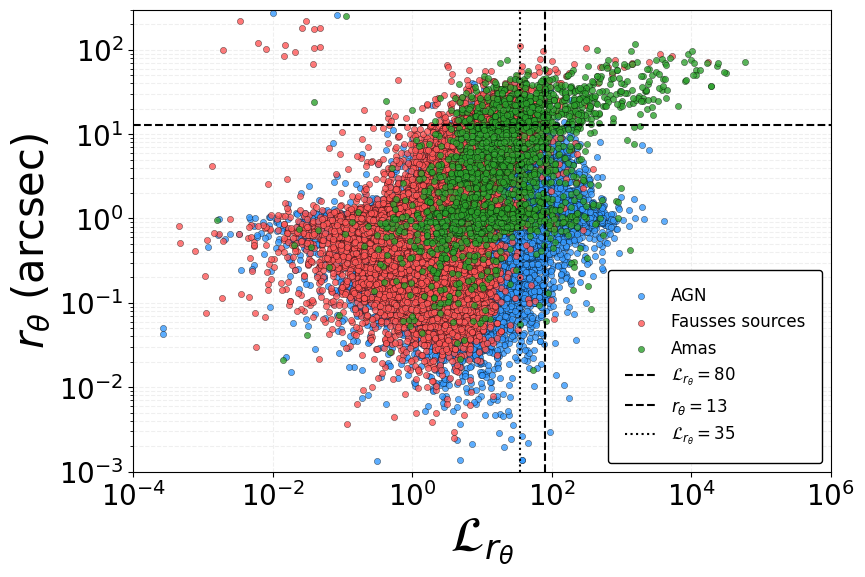

In [51]:
plot_ext_vs_extlike(
    colors =[ '#3399ff', '#FF5555', '#2ca02c'],
    labels = ['AGN', 'Fausses sources', 'Amas'],
    data1=data_match_AGN,
    data2=data_match_NC,
    data3=data_match_clusters,
    paint_c1=False,
    paint_c2=False,
    ext_like_c1=EXT_LIKE_C1_new, 
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/Amas_AGN_NC_C1C2.png"
)

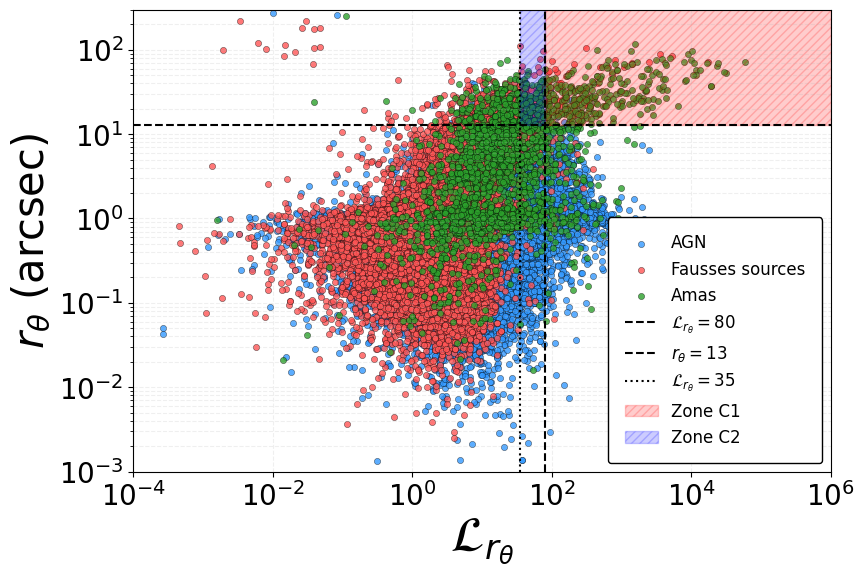

In [52]:
plot_ext_vs_extlike(
    colors =[ '#3399ff', '#FF5555', '#2ca02c'],
    labels = ['AGN', 'Fausses sources', 'Amas'],
    data1=data_match_AGN,
    data2=data_match_NC,
    data3=data_match_clusters,
    paint_c1=True,
    paint_c2=True,
    ext_like_c1=EXT_LIKE_C1_new, 
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/Amas_AGN_NC_paintC1C2.png"
)

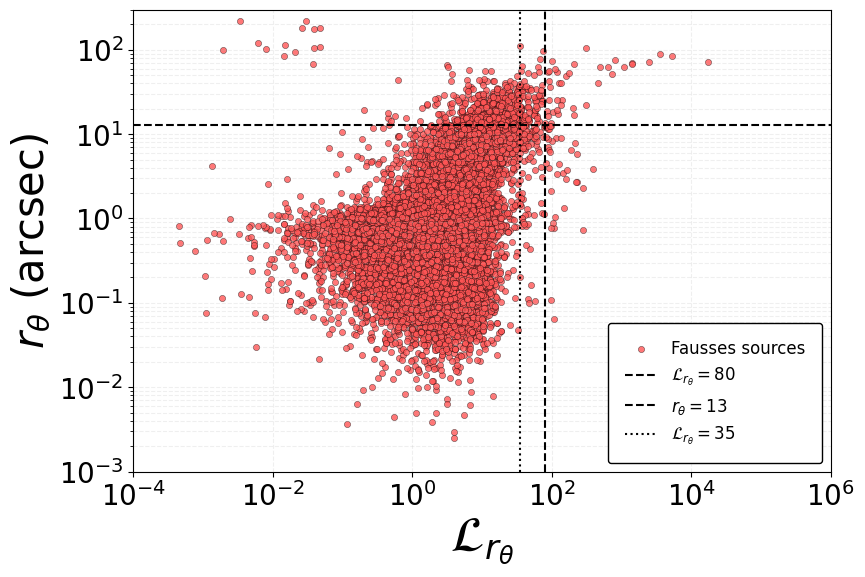

In [44]:
plot_ext_vs_extlike(
    colors = ['#FF5555'],
    labels = ['Fausses sources'],
    data1=data_match_NC,
    paint_c1=False,
    paint_c2=False,
    ext_like_c1=EXT_LIKE_C1_new,  
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/AGN_C1_C2.png"
)

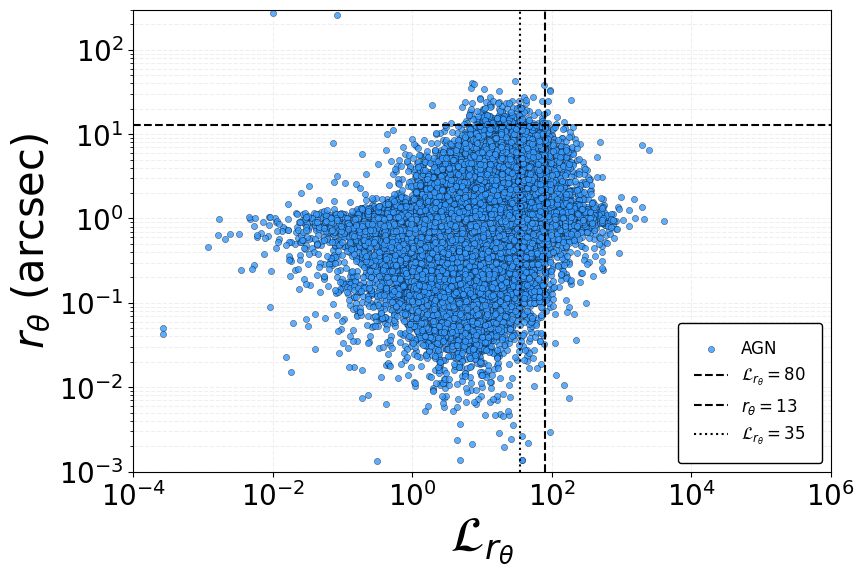

In [45]:
plot_ext_vs_extlike(
    colors = ['#3399ff'],
    labels = ['AGN'],
    data1=data_match_AGN,
    paint_c1=False,
    paint_c2=False,
    ext_like_c1=EXT_LIKE_C1_new,
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/NC_C1_C2.png"
)

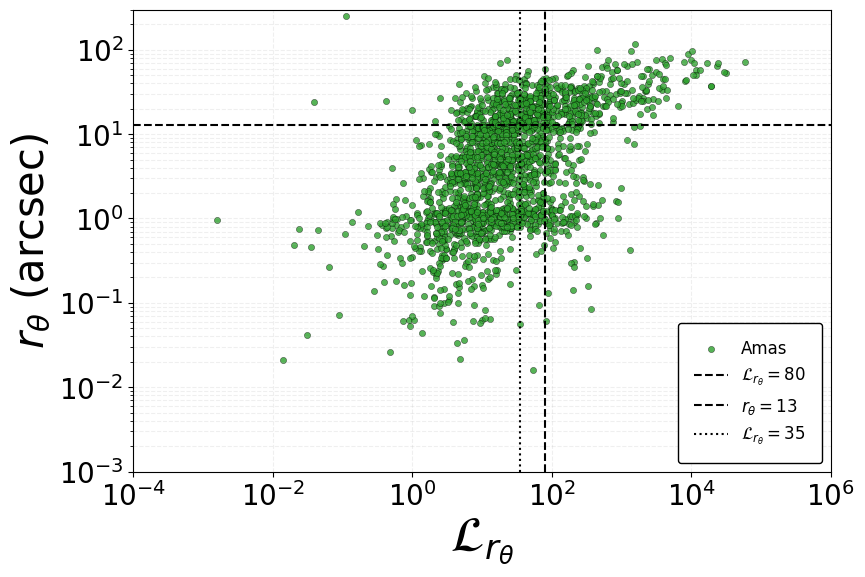

In [46]:
plot_ext_vs_extlike(
    colors = ['#2ca02c'],
    labels = ['Amas'],
    data1=data_match_clusters,
    paint_c1=False,
    paint_c2=False,
    ext_like_c1=EXT_LIKE_C1_new,
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/Amas_C1_C2.png"
)

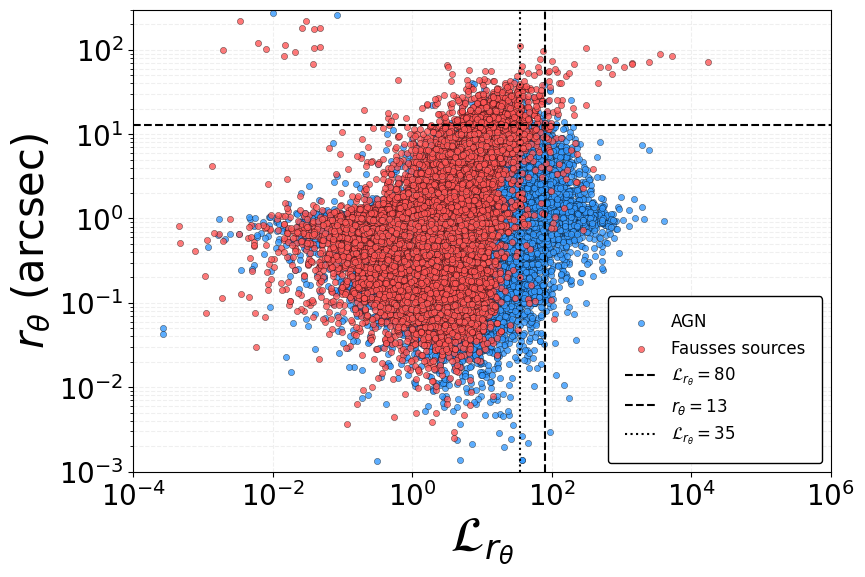

In [47]:
plot_ext_vs_extlike(
    colors =[ '#3399ff', '#FF5555'],
    labels = ['AGN', 'Fausses sources'],
    data1=data_match_AGN,
    data2=data_match_NC,
    paint_c1=False,
    paint_c2=False,
    ext_like_c1=EXT_LIKE_C1_new, 
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/AGN_NC.png"
)

In [48]:
def plot_ext_vs_extlike_new(data, label, palette,
                       ext_like_c1=None, ext_like_c2=None, ext_c1_c2=None, 
                       save_path=None):
    """
    Trace EXT vs EXT_LIKE avec coloration des zones C1 et C2
    
    Args:
        data: Table Astropy (doit contenir 'EXT' et 'EXT_LIKE')
        ext_like_c1: Seuil EXT_LIKE pour la zone C1
        ext_like_c2: Seuil EXT_LIKE pour la zone C2
        ext_c1_c2: Seuil EXT pour les zones C1/C2
        title: Titre du plot
        save_path: Chemin de sauvegarde
    """
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Couleurs par défaut
    default_color = palette[0] #'#1f77b4'  # Bleu
    c1_color = palette[1] #'red'           # Zone C1
    c2_color = palette[2] #'blue'          # Zone C2
    
    # Séparation des points selon les zones
    mask_c1 = (data['EXT_LIKE'] >= ext_like_c1) & (data['EXT'] >= ext_c1_c2) if ext_like_c1 is not None else None
    mask_c2 = (data['EXT_LIKE'] >= ext_like_c2) & (data['EXT_LIKE'] < ext_like_c1) & (data['EXT'] >= ext_c1_c2) if (ext_like_c2 is not None and ext_like_c1 is not None) else None
    mask_default = ~mask_c1 & ~mask_c2 if (mask_c1 is not None and mask_c2 is not None) else None
    
    # Plot des points
    if mask_c1 is not None and mask_c2 is not None:
        # Points normaux
        ax.scatter(data['EXT_LIKE'][mask_default], data['EXT'][mask_default],
                  color=default_color, marker='o', alpha=0.8,
                  edgecolor='k', linewidth=0.5, label=label)
        
        # Points zone C2
        ax.scatter(data['EXT_LIKE'][mask_c2], data['EXT'][mask_c2],
                  color=c2_color, marker='o', alpha=0.8,
                  edgecolor='k', linewidth=0.5, label=label + ' C2')
        
        # Points zone C1
        ax.scatter(data['EXT_LIKE'][mask_c1], data['EXT'][mask_c1],
                  color=c1_color, marker='o', alpha=0.8,
                  edgecolor='k', linewidth=0.5, label=label+' C1')
    else:
        # Tous les points si pas de zones définies
        ax.scatter(data['EXT_LIKE'], data['EXT'],
                  color=default_color, marker='o', alpha=0.5,
                  edgecolor='k', linewidth=0.5)

    # Configuration des axes en log
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(3e-4, 3e2)
    # Labels
    ax.set_xlabel(r'$\mathcal{L}_{r_\theta}$', fontsize=20)
    ax.set_ylabel(r'$r_\theta$ (arcsec)', fontsize=20)
    
    # Format des ticks
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    
    #plt.title(title, fontsize=16, pad=20)
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend(fontsize=12, framealpha=1)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

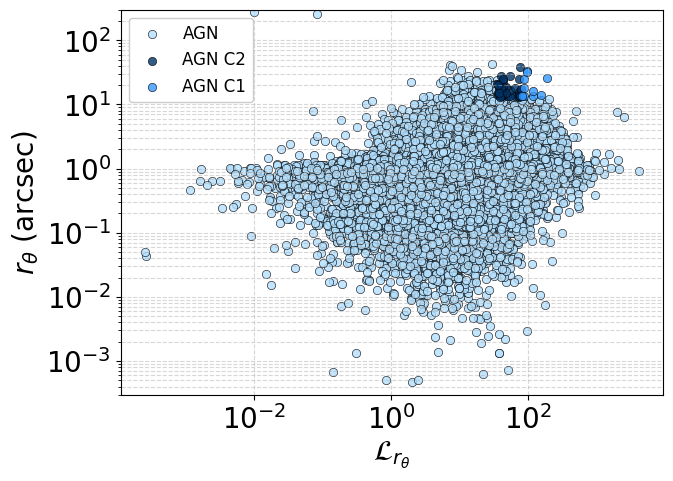

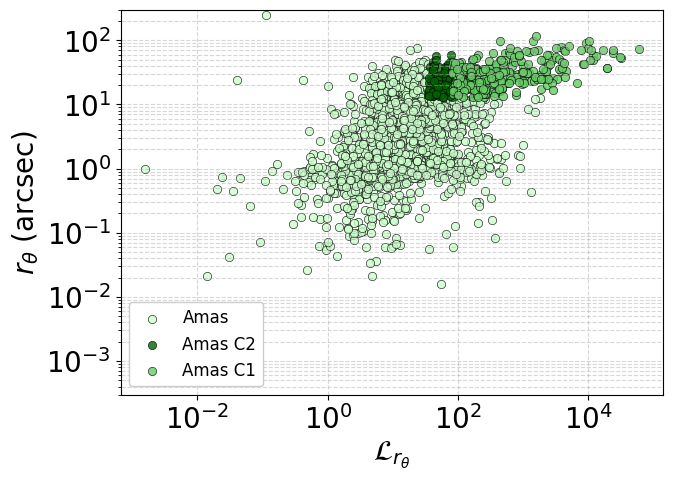

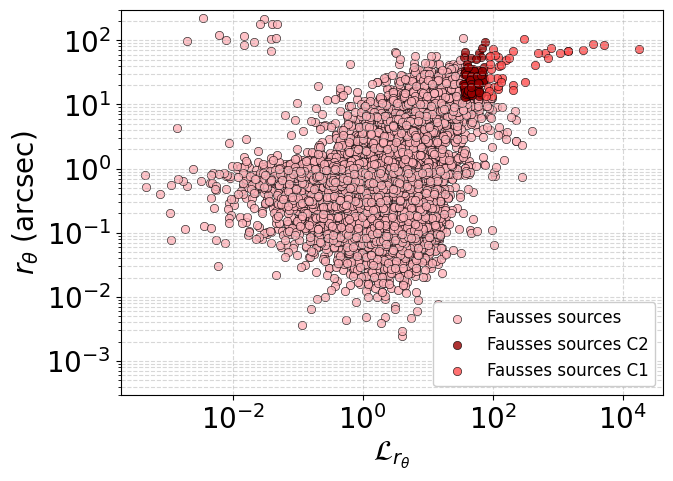

In [49]:
greens = ['#ccffcc', '#66cc66', '#006600']
blues = ['#b3e0ff', '#3399ff', '#003366']
reds = ['#ffb3ba', '#ff4d4d', '#990000']

plot_ext_vs_extlike_new(data_match_AGN, 
    label = 'AGN',
    palette = blues,
    ext_like_c1=EXT_LIKE_C1_new,
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/AGN_coloredC1C2.png")

plot_ext_vs_extlike_new(data_match_clusters, 
    label = 'Amas',
    palette = greens,
    ext_like_c1=EXT_LIKE_C1_new,
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/Amas_coloredC1C2.png")

plot_ext_vs_extlike_new(data_match_NC, 
    label = 'Fausses sources',
    palette = reds,
    ext_like_c1=EXT_LIKE_C1_new,
    ext_like_c2=EXT_LIKE_C2_new,
    ext_c1_c2=EXT_C1_C2_new,
    save_path=f"/local/home/sh275430/Documents/TransformerProject/results/Correl_to_find_spurious/SimulationTOT/PrivilegeAmas/{dossier}/NC_coloredC1C2.png")

In [50]:
data_match_clusters[0]

BOX_ID_SRC,INST0,BAND0,INST1,BAND1,INST0_EXP,INST1_EXP,INST0_GAPFLAG,INST1_GAPFLAG,GAP_NEIGHBOUR,INPUT_X_IMA,INPUT_Y_IMA,PNT_DET_ML,EXT_DET_ML,EPN_DET_ML,DBL_DET_ML,EPN_ML_EXT,PNT_X_IMA,PNT_X_IMA_ERR,PNT_Y_IMA,PNT_IMA_ERR,PNT_RA,PNT_DEC,PNT_RADEC_ERR,PNT_RATE_MOS,PNT_RATE_MOS_ERR,PNT_RATE_PN,PNT_RATE_PN_ERR,PNT_SCTS_MOS,PNT_SCTS_MOS_ERR,PNT_SCTS_PN,PNT_SCTS_PN_ERR,PNT_BG_MAP_MOS,PNT_BG_MAP_PN,PNT_PIX_DEV,PNT_N_ITER,PNT_CUTRAD,EXT_LIKE,EXT,EXT_ERR,EXT_X_IMA,EXT_X_IMA_ERR,EXT_Y_IMA,EXT_Y_IMA_ERR,EXT_RA,EXT_DEC,EXT_RADEC_ERR,EXT_RATE_MOS,EXT_RATE_MOS_ERR,EXT_RATE_PN,EXT_RATE_PN_ERR,EXT_SCTS_MOS,EXT_SCTS_MOS_ERR,EXT_SCTS_PN,EXT_SCTS_PN_ERR,EXT_BG_MAP_MOS,EXT_BG_MAP_PN,EXT_PIX_DEV,EXT_N_ITER,EXT_CUTRAD,EPN_LIKE_EXT,EPN_LIKE_PNT,EPN_EXT,EPN_EXT_ERR,EPN_RATIO,EPN_RATIO_ERR,EPN_X_IMA,EPN_X_IMA_ERR,EPN_Y_IMA,EPN_Y_IMA_ERR,EPN_RA,EPN_DEC,EPN_RADEC_ERR,EPN_RATE_MOS,EPN_RATE_MOS_ERR,EPN_RATE_PN,EPN_RATE_PN_ERR,EPN_SCTS_MOS,EPN_SCTS_MOS_ERR,EPN_SCTS_PN,EPN_SCTS_PN_ERR,EPN_BG_MAP_MOS,EPN_BG_MAP_PN,EPN_PIX_DEV,EPN_N_ITER,EPN_CUTRAD,DBL_LIKE,DBL_SEP,DBL_SEP_ERR,DBL_RATIO,DBL_RATIO_ERR,DBL_THETA,DBL_X_IMA,DBL_X_IMA_ERR,DBL_Y_IMA,DBL_Y_IMA_ERR,DBL_RA,DBL_DEC,DBL_RADEC_ERR,DBL_RATE_MOS,DBL_RATE_MOS_ERR,DBL_RATE_PN,DBL_RATE_PN_ERR,DBL_SCTS_MOS,DBL_SCTS_MOS_ERR,DBL_SCTS_PN,DBL_SCTS_PN_ERR,DBL_BG_MAP_MOS,DBL_BG_MAP_PN,DBL_PIX_DEV,DBL_N_ITER,DBL_CUTRAD,ID_Xamin,R.A.,Dec,flux_ABS
int32,bytes8,bytes8,bytes8,bytes8,float64,float64,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int64,float64,float64,float64
1512,MOS,b2,PN,b2,62960.028203125,32684.128046875,44,36,1,1219.0000000000075,521.9999999999862,102.25138758207686,98.43377813173014,97.55826975337159,97.10360341868628,-2.9514683007641906,1219.0000000000075,--,521.9999999999862,--,147.0299589940846,1.5458157530603327,--,0.00038087592193958324,--,0.0012206056992471585,--,24.081484182148387,--,40.02626743355748,--,0.029629628223764505,0.07673368303516563,0.0,16,37.4439582824707,2.8949697994689814,0.14789759355284304,--,1219.4142358653557,--,521.3894086203109,--,147.03024669054656,1.5453917038010716,--,0.00032592573868116855,--,0.0007462845668189772,--,28.911720952091095,--,34.41811438761854,--,0.02711518950958298,0.08263079454509091,0.5031645245934449,136,37.4439582824707,0.0,0.0,55.847676658532905,--,2.985515096574524,--,1219.0000000000075,--,521.9999999999862,--,147.0299589940846,1.5458157530603327,--,0.0004022827114046883,--,0.0013046309806399965,--,25.535094613502725,--,41.923612151009394,--,0.02887293356923336,0.07473857817980085,0.0,141,37.4439582824707,0.0,2.1122616518355253,--,0.0010000568020117548,--,3.7609161636009307e-121,1219.020079690481,--,521.7020596565873,--,147.0299729120835,1.545608853306471,--,0.0003743220049596883,--,0.0012332843991278407,--,24.232561812957183,--,40.34721020991466,--,0.029550982918814583,0.07639620377506344,0.0,79,37.4439582824707,1441,147.02345275878906,1.5497878789901731,6.06e-15
